In [268]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.data import Dataset
import db
import sys
import pymongo
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras import initializers
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
transferdb = myclient["transferdb"]

collfalse = transferdb["labelled__false_tweets"]
colltrue = transferdb["labelled_tweets"]
df_false = pd.DataFrame(list(collfalse.find()))
df_true = pd.DataFrame(list(colltrue.find()))
df_merged = pd.concat([df_false, df_true])

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

In [269]:
def preprocess_features(df):
    selected_features = df["tweet_text"].tolist()
    return selected_features

def preprocess_targets(df):
    output_targets = pd.DataFrame()
    output_targets["label_int"] = (df["label"] == "True").astype(float)
    return output_targets["label_int"].tolist()
    

    
    

In [291]:
# making the training sets
shuffeled = df_merged.sample(frac=1)
training_examples = preprocess_features(shuffeled.head(100))
training_targets = preprocess_targets(shuffeled.head(100))

validation_examples = preprocess_features(shuffeled.tail(50))
validation_targets = preprocess_targets(shuffeled.tail(50))





In [271]:
print("Training examples summary:")
display.display(training_examples)
print("Validation examples summary:")
display.display(validation_examples)

print("Training targets summary:")
display.display(training_targets)
print("Validation targets summary:")
display.display(validation_targets)

Training examples summary:


[u'Championship LIVE: Transfer news | Sheffield United want Hogan | Middlesbrough in talks with Bolasie | 21 August http:// dlvr.it/QgZtjV pic.twitter.com/QTNkdhJy3m',
 u'Brazilian goalkeeper Alisson is in Liverpool to complete a medical ahead of his \xa367m move from Roma. It is the final hurdle in the transfer, according to Sky in Italy, with Alisson having travelled to England on a private jet on Wednesday after already agreeing a 5 year deal.',
 u'Jose Mourinho in talks to sign \xa3152m duo as key Manchester United star nears imminent exit #epl : Manchester United manager Jose Mourinho is reportedly prioritising a transfer move for \xa3100million Lazio midfielder Sergej M... https:// eplfeeds.com/article/jose-m ourinho-in-talks-to-sign-152m-duo-as-key-manchester-united-star-nears-imminent-exit \u2026 pic.twitter.com/TmO1mBuYL8',
 u'Ahmed Musa\'s agent says the Leicester forward is in talks with Turkish side Galatasaray. Speaking to radio station Radyospor, Musa\'s agent William D\u

Validation examples summary:


[u'Manchester United are in talks with Fenerbahce regarding a loan switch for Marcos Rojo, reports Fanatik.',
 u'[ @DiMarzio ] understand AS Roma are in talks with Tottenham target Malcom\u2019s representatives over a transfer. [L\u2019\xc9quipe] meanwhile reports Leicester are also interested with Inter agreeing personal terms with the player but not being able to agree a fee with Bordeaux. #THFC #COYS pic.twitter.com/wRqlMgSYxS',
 u"Tottenham Hotspur transfer news : Rennes in talks to sign Georges-Kevin N'Koudou: French side Rennes are in talks to sign Tottenham Hotspur midfielder Georges-Kevin N\u2019Koudou, according to L\u2019Equipe. The 23-year-old has failed to establish himself in Ma.. http:// dld.bz/gXAPe",
 u'DEAL DONE : Nottingham Forest have signed Sam Byram from West Ham on a season-long loan. (Source: @NFFC )',
 u'DONE DEAL: Birmingham sign Bournemouth winger Maloney on loan #epl : Birmingham City have signed Bournemouth winger Connor Maloney on loan for the 2018/19 seaso

Training targets summary:


[0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0]

Validation targets summary:


[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0]

In [272]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [273]:
ndarr = np.array(training_targets)


x_train, x_val = ngram_vectorize(training_examples, ndarr, validation_examples)
print(x_val)

  (0, 50)	0.24070625
  (0, 51)	0.277176
  (0, 194)	0.22307333
  (0, 264)	0.15113522
  (0, 266)	0.18317726
  (0, 329)	0.30886996
  (0, 346)	0.29501143
  (0, 348)	0.3338989
  (0, 464)	0.277176
  (0, 526)	0.18099223
  (0, 530)	0.2198797
  (0, 592)	0.2887195
  (0, 593)	0.43888763
  (0, 630)	0.17675553
  (1, 30)	0.21924525
  (1, 42)	0.18559775
  (1, 50)	0.22517037
  (1, 51)	0.12964313
  (1, 62)	0.14111817
  (1, 85)	0.21924525
  (1, 98)	0.20528027
  (1, 121)	0.06919651
  (1, 182)	0.16591522
  (1, 264)	0.07069026
  (1, 266)	0.08567724
  :	:
  (98, 604)	0.12568052
  (98, 605)	0.12568052
  (98, 606)	0.12568052
  (98, 607)	0.12568052
  (98, 644)	0.115102075
  (98, 645)	0.12568052
  (99, 23)	0.20584135
  (99, 24)	0.20584135
  (99, 50)	0.17521045
  (99, 51)	0.20175683
  (99, 264)	0.11001156
  (99, 266)	0.13333501
  (99, 363)	0.3026096
  (99, 491)	0.20175683
  (99, 496)	0.23647223
  (99, 497)	0.27719077
  (99, 503)	0.27719077
  (99, 520)	0.2888361
  (99, 526)	0.13174452
  (99, 529)	0.2304254
  (99,

In [274]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [275]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model


In [276]:
def plot_res(history):
    
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Training & Validation Accuracy")
    plt.tight_layout()
    plt.plot(history['acc'], label="training")
    plt.plot(history['val_acc'], label="validation")
    plt.legend()
    
    

In [277]:
def roc_curve(history):
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
        validation_targets, history['val_acc'][len(history['val_acc'])-len(validation_targets):len(history['val_acc'])])
    plt.plot(false_positive_rate, true_positive_rate, label="our model")
    plt.plot([0, 1], [0, 1], label="random classifier")
    _ = plt.legend(loc=2)

In [278]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = explore_data.get_num_classes(train_labels)
    num_classes = 2
#     unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
#     if len(unexpected_labels):
#         raise ValueError('Unexpected label values found in the validation set:'
#                          ' {unexpected_labels}. Please make sure that the '
#                          'labels in the validation set are in the same range '
#                          'as training labels.'.format(
#                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
#     print('Validation accuracy: {acc}, loss: {loss}'.format(
#             acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Compute training and validation loss.
    
    # Plot Results
    roc_curve(history)
    
    # Save model.
    model.save('twitter_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

Train on 100 samples, validate on 100 samples
Epoch 1/1000
 - 2s - loss: 0.6909 - acc: 0.5000 - val_loss: 0.7066 - val_acc: 0.3400
Epoch 2/1000
 - 0s - loss: 0.6948 - acc: 0.4500 - val_loss: 0.7065 - val_acc: 0.3400
Epoch 3/1000
 - 0s - loss: 0.6914 - acc: 0.4900 - val_loss: 0.7065 - val_acc: 0.3400
Epoch 4/1000
 - 0s - loss: 0.6960 - acc: 0.4400 - val_loss: 0.7064 - val_acc: 0.3400
Epoch 5/1000
 - 0s - loss: 0.6925 - acc: 0.4800 - val_loss: 0.7064 - val_acc: 0.3400
Epoch 6/1000
 - 0s - loss: 0.6930 - acc: 0.5100 - val_loss: 0.7064 - val_acc: 0.3400
Epoch 7/1000
 - 0s - loss: 0.6930 - acc: 0.4700 - val_loss: 0.7063 - val_acc: 0.3400
Epoch 8/1000
 - 0s - loss: 0.6954 - acc: 0.4400 - val_loss: 0.7063 - val_acc: 0.3400
Epoch 9/1000
 - 0s - loss: 0.6914 - acc: 0.4700 - val_loss: 0.7063 - val_acc: 0.3400
Epoch 10/1000
 - 0s - loss: 0.6912 - acc: 0.4500 - val_loss: 0.7062 - val_acc: 0.3400
Epoch 11/1000
 - 0s - loss: 0.6923 - acc: 0.4700 - val_loss: 0.7062 - val_acc: 0.3400
Epoch 12/1000
 - 

Epoch 96/1000
 - 0s - loss: 0.6924 - acc: 0.4900 - val_loss: 0.7033 - val_acc: 0.3600
Epoch 97/1000
 - 0s - loss: 0.6896 - acc: 0.5200 - val_loss: 0.7033 - val_acc: 0.3600
Epoch 98/1000
 - 0s - loss: 0.6857 - acc: 0.5400 - val_loss: 0.7032 - val_acc: 0.3600
Epoch 99/1000
 - 0s - loss: 0.6928 - acc: 0.4800 - val_loss: 0.7032 - val_acc: 0.3700
Epoch 100/1000
 - 0s - loss: 0.6910 - acc: 0.4800 - val_loss: 0.7032 - val_acc: 0.3700
Epoch 101/1000
 - 0s - loss: 0.6923 - acc: 0.4900 - val_loss: 0.7031 - val_acc: 0.3700
Epoch 102/1000
 - 0s - loss: 0.6879 - acc: 0.5200 - val_loss: 0.7031 - val_acc: 0.3700
Epoch 103/1000
 - 0s - loss: 0.6881 - acc: 0.5500 - val_loss: 0.7031 - val_acc: 0.3700
Epoch 104/1000
 - 0s - loss: 0.6897 - acc: 0.4800 - val_loss: 0.7030 - val_acc: 0.3700
Epoch 105/1000
 - 0s - loss: 0.6896 - acc: 0.4800 - val_loss: 0.7030 - val_acc: 0.3700
Epoch 106/1000
 - 0s - loss: 0.6890 - acc: 0.4900 - val_loss: 0.7030 - val_acc: 0.3700
Epoch 107/1000
 - 0s - loss: 0.6925 - acc: 0.47

Epoch 191/1000
 - 0s - loss: 0.6898 - acc: 0.5400 - val_loss: 0.7001 - val_acc: 0.3700
Epoch 192/1000
 - 0s - loss: 0.6856 - acc: 0.5300 - val_loss: 0.7001 - val_acc: 0.3700
Epoch 193/1000
 - 0s - loss: 0.6864 - acc: 0.5000 - val_loss: 0.7001 - val_acc: 0.3700
Epoch 194/1000
 - 0s - loss: 0.6894 - acc: 0.5200 - val_loss: 0.7000 - val_acc: 0.3700
Epoch 195/1000
 - 0s - loss: 0.6866 - acc: 0.5400 - val_loss: 0.7000 - val_acc: 0.3700
Epoch 196/1000
 - 0s - loss: 0.6940 - acc: 0.5100 - val_loss: 0.7000 - val_acc: 0.3700
Epoch 197/1000
 - 0s - loss: 0.6869 - acc: 0.5200 - val_loss: 0.6999 - val_acc: 0.3700
Epoch 198/1000
 - 0s - loss: 0.6875 - acc: 0.4700 - val_loss: 0.6999 - val_acc: 0.3700
Epoch 199/1000
 - 0s - loss: 0.6906 - acc: 0.5500 - val_loss: 0.6999 - val_acc: 0.3700
Epoch 200/1000
 - 0s - loss: 0.6899 - acc: 0.5200 - val_loss: 0.6998 - val_acc: 0.3700
Epoch 201/1000
 - 0s - loss: 0.6887 - acc: 0.5200 - val_loss: 0.6998 - val_acc: 0.3700
Epoch 202/1000
 - 0s - loss: 0.6877 - acc: 

Epoch 286/1000
 - 0s - loss: 0.6816 - acc: 0.5800 - val_loss: 0.6971 - val_acc: 0.3900
Epoch 287/1000
 - 0s - loss: 0.6825 - acc: 0.5500 - val_loss: 0.6970 - val_acc: 0.3900
Epoch 288/1000
 - 0s - loss: 0.6843 - acc: 0.5600 - val_loss: 0.6970 - val_acc: 0.4100
Epoch 289/1000
 - 0s - loss: 0.6828 - acc: 0.6200 - val_loss: 0.6970 - val_acc: 0.4100
Epoch 290/1000
 - 0s - loss: 0.6846 - acc: 0.5400 - val_loss: 0.6969 - val_acc: 0.4100
Epoch 291/1000
 - 0s - loss: 0.6825 - acc: 0.5900 - val_loss: 0.6969 - val_acc: 0.4100
Epoch 292/1000
 - 0s - loss: 0.6831 - acc: 0.5900 - val_loss: 0.6969 - val_acc: 0.4100
Epoch 293/1000
 - 0s - loss: 0.6810 - acc: 0.5800 - val_loss: 0.6969 - val_acc: 0.4100
Epoch 294/1000
 - 0s - loss: 0.6824 - acc: 0.5700 - val_loss: 0.6968 - val_acc: 0.4100
Epoch 295/1000
 - 0s - loss: 0.6841 - acc: 0.5500 - val_loss: 0.6968 - val_acc: 0.4100
Epoch 296/1000
 - 0s - loss: 0.6840 - acc: 0.6000 - val_loss: 0.6968 - val_acc: 0.4100
Epoch 297/1000
 - 0s - loss: 0.6873 - acc: 

 - 0s - loss: 0.6798 - acc: 0.6700 - val_loss: 0.6941 - val_acc: 0.4800
Epoch 381/1000
 - 0s - loss: 0.6810 - acc: 0.6000 - val_loss: 0.6941 - val_acc: 0.4800
Epoch 382/1000
 - 0s - loss: 0.6816 - acc: 0.5600 - val_loss: 0.6941 - val_acc: 0.4900
Epoch 383/1000
 - 0s - loss: 0.6835 - acc: 0.5700 - val_loss: 0.6940 - val_acc: 0.4900
Epoch 384/1000
 - 0s - loss: 0.6790 - acc: 0.5800 - val_loss: 0.6940 - val_acc: 0.4900
Epoch 385/1000
 - 0s - loss: 0.6850 - acc: 0.5900 - val_loss: 0.6940 - val_acc: 0.4900
Epoch 386/1000
 - 0s - loss: 0.6825 - acc: 0.6100 - val_loss: 0.6939 - val_acc: 0.4900
Epoch 387/1000
 - 0s - loss: 0.6807 - acc: 0.5700 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 388/1000
 - 0s - loss: 0.6798 - acc: 0.6000 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 389/1000
 - 0s - loss: 0.6820 - acc: 0.6200 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 390/1000
 - 0s - loss: 0.6822 - acc: 0.6100 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 391/1000
 - 0s - loss: 0.6788 - acc: 0.6500 - val_lo

Epoch 475/1000
 - 0s - loss: 0.6806 - acc: 0.5500 - val_loss: 0.6912 - val_acc: 0.5700
Epoch 476/1000
 - 0s - loss: 0.6782 - acc: 0.6300 - val_loss: 0.6912 - val_acc: 0.5700
Epoch 477/1000
 - 0s - loss: 0.6793 - acc: 0.6300 - val_loss: 0.6911 - val_acc: 0.5700
Epoch 478/1000
 - 0s - loss: 0.6776 - acc: 0.6200 - val_loss: 0.6911 - val_acc: 0.5700
Epoch 479/1000
 - 0s - loss: 0.6794 - acc: 0.5900 - val_loss: 0.6911 - val_acc: 0.5700
Epoch 480/1000
 - 0s - loss: 0.6745 - acc: 0.6300 - val_loss: 0.6910 - val_acc: 0.5700
Epoch 481/1000
 - 0s - loss: 0.6748 - acc: 0.6700 - val_loss: 0.6910 - val_acc: 0.5700
Epoch 482/1000
 - 0s - loss: 0.6796 - acc: 0.6200 - val_loss: 0.6910 - val_acc: 0.5700
Epoch 483/1000
 - 0s - loss: 0.6779 - acc: 0.6600 - val_loss: 0.6909 - val_acc: 0.5700
Epoch 484/1000
 - 0s - loss: 0.6747 - acc: 0.6400 - val_loss: 0.6909 - val_acc: 0.5700
Epoch 485/1000
 - 0s - loss: 0.6763 - acc: 0.6500 - val_loss: 0.6909 - val_acc: 0.5700
Epoch 486/1000
 - 0s - loss: 0.6757 - acc: 

 - 0s - loss: 0.6780 - acc: 0.6000 - val_loss: 0.6883 - val_acc: 0.6000
Epoch 570/1000
 - 0s - loss: 0.6713 - acc: 0.6900 - val_loss: 0.6883 - val_acc: 0.6000
Epoch 571/1000
 - 0s - loss: 0.6763 - acc: 0.6400 - val_loss: 0.6883 - val_acc: 0.6000
Epoch 572/1000
 - 0s - loss: 0.6719 - acc: 0.7300 - val_loss: 0.6883 - val_acc: 0.6000
Epoch 573/1000
 - 0s - loss: 0.6716 - acc: 0.7200 - val_loss: 0.6882 - val_acc: 0.6000
Epoch 574/1000
 - 0s - loss: 0.6761 - acc: 0.6800 - val_loss: 0.6882 - val_acc: 0.6000
Epoch 575/1000
 - 0s - loss: 0.6766 - acc: 0.6800 - val_loss: 0.6882 - val_acc: 0.6000
Epoch 576/1000
 - 0s - loss: 0.6740 - acc: 0.6600 - val_loss: 0.6881 - val_acc: 0.6000
Epoch 577/1000
 - 0s - loss: 0.6757 - acc: 0.6700 - val_loss: 0.6881 - val_acc: 0.6000
Epoch 578/1000
 - 0s - loss: 0.6710 - acc: 0.7200 - val_loss: 0.6881 - val_acc: 0.6000
Epoch 579/1000
 - 0s - loss: 0.6736 - acc: 0.6700 - val_loss: 0.6880 - val_acc: 0.6000
Epoch 580/1000
 - 0s - loss: 0.6724 - acc: 0.7200 - val_lo

Epoch 664/1000
 - 0s - loss: 0.6696 - acc: 0.7500 - val_loss: 0.6855 - val_acc: 0.6000
Epoch 665/1000
 - 0s - loss: 0.6720 - acc: 0.6800 - val_loss: 0.6855 - val_acc: 0.6000
Epoch 666/1000
 - 0s - loss: 0.6739 - acc: 0.6900 - val_loss: 0.6854 - val_acc: 0.6000
Epoch 667/1000
 - 0s - loss: 0.6747 - acc: 0.6600 - val_loss: 0.6854 - val_acc: 0.6000
Epoch 668/1000
 - 0s - loss: 0.6720 - acc: 0.7300 - val_loss: 0.6854 - val_acc: 0.6000
Epoch 669/1000
 - 0s - loss: 0.6727 - acc: 0.7200 - val_loss: 0.6854 - val_acc: 0.6000
Epoch 670/1000
 - 0s - loss: 0.6705 - acc: 0.7500 - val_loss: 0.6853 - val_acc: 0.6000
Epoch 671/1000
 - 0s - loss: 0.6684 - acc: 0.7100 - val_loss: 0.6853 - val_acc: 0.6000
Epoch 672/1000
 - 0s - loss: 0.6734 - acc: 0.7500 - val_loss: 0.6853 - val_acc: 0.6000
Epoch 673/1000
 - 0s - loss: 0.6738 - acc: 0.6900 - val_loss: 0.6852 - val_acc: 0.6000
Epoch 674/1000
 - 0s - loss: 0.6712 - acc: 0.7100 - val_loss: 0.6852 - val_acc: 0.6000
Epoch 675/1000
 - 0s - loss: 0.6717 - acc: 

 - 0s - loss: 0.6710 - acc: 0.7200 - val_loss: 0.6827 - val_acc: 0.6300
Epoch 759/1000
 - 0s - loss: 0.6683 - acc: 0.7300 - val_loss: 0.6827 - val_acc: 0.6300
Epoch 760/1000
 - 0s - loss: 0.6708 - acc: 0.7100 - val_loss: 0.6827 - val_acc: 0.6300
Epoch 761/1000
 - 0s - loss: 0.6680 - acc: 0.7400 - val_loss: 0.6826 - val_acc: 0.6300
Epoch 762/1000
 - 0s - loss: 0.6676 - acc: 0.7300 - val_loss: 0.6826 - val_acc: 0.6300
Epoch 763/1000
 - 0s - loss: 0.6659 - acc: 0.7700 - val_loss: 0.6826 - val_acc: 0.6300
Epoch 764/1000
 - 0s - loss: 0.6678 - acc: 0.7400 - val_loss: 0.6826 - val_acc: 0.6300
Epoch 765/1000
 - 0s - loss: 0.6690 - acc: 0.7700 - val_loss: 0.6825 - val_acc: 0.6300
Epoch 766/1000
 - 0s - loss: 0.6689 - acc: 0.6900 - val_loss: 0.6825 - val_acc: 0.6300
Epoch 767/1000
 - 0s - loss: 0.6658 - acc: 0.8000 - val_loss: 0.6825 - val_acc: 0.6300
Epoch 768/1000
 - 0s - loss: 0.6670 - acc: 0.7600 - val_loss: 0.6824 - val_acc: 0.6300
Epoch 769/1000
 - 0s - loss: 0.6668 - acc: 0.7600 - val_lo

Epoch 853/1000
 - 0s - loss: 0.6644 - acc: 0.7900 - val_loss: 0.6800 - val_acc: 0.6700
Epoch 854/1000
 - 0s - loss: 0.6637 - acc: 0.7400 - val_loss: 0.6800 - val_acc: 0.6700
Epoch 855/1000
 - 0s - loss: 0.6616 - acc: 0.7900 - val_loss: 0.6799 - val_acc: 0.6700
Epoch 856/1000
 - 0s - loss: 0.6670 - acc: 0.7500 - val_loss: 0.6799 - val_acc: 0.6800
Epoch 857/1000
 - 0s - loss: 0.6658 - acc: 0.7800 - val_loss: 0.6799 - val_acc: 0.6800
Epoch 858/1000
 - 0s - loss: 0.6637 - acc: 0.8100 - val_loss: 0.6798 - val_acc: 0.6800
Epoch 859/1000
 - 0s - loss: 0.6637 - acc: 0.7900 - val_loss: 0.6798 - val_acc: 0.6800
Epoch 860/1000
 - 0s - loss: 0.6627 - acc: 0.7600 - val_loss: 0.6798 - val_acc: 0.6800
Epoch 861/1000
 - 0s - loss: 0.6655 - acc: 0.7700 - val_loss: 0.6798 - val_acc: 0.6800
Epoch 862/1000
 - 0s - loss: 0.6670 - acc: 0.8000 - val_loss: 0.6797 - val_acc: 0.6800
Epoch 863/1000
 - 0s - loss: 0.6651 - acc: 0.8000 - val_loss: 0.6797 - val_acc: 0.6800
Epoch 864/1000
 - 0s - loss: 0.6596 - acc: 

 - 0s - loss: 0.6585 - acc: 0.8100 - val_loss: 0.6773 - val_acc: 0.6900
Epoch 948/1000
 - 0s - loss: 0.6611 - acc: 0.7900 - val_loss: 0.6772 - val_acc: 0.6900
Epoch 949/1000
 - 0s - loss: 0.6603 - acc: 0.8200 - val_loss: 0.6772 - val_acc: 0.6900
Epoch 950/1000
 - 0s - loss: 0.6644 - acc: 0.7400 - val_loss: 0.6772 - val_acc: 0.6900
Epoch 951/1000
 - 0s - loss: 0.6622 - acc: 0.7800 - val_loss: 0.6772 - val_acc: 0.6900
Epoch 952/1000
 - 0s - loss: 0.6597 - acc: 0.8300 - val_loss: 0.6771 - val_acc: 0.6900
Epoch 953/1000
 - 0s - loss: 0.6629 - acc: 0.8100 - val_loss: 0.6771 - val_acc: 0.6900
Epoch 954/1000
 - 0s - loss: 0.6621 - acc: 0.8100 - val_loss: 0.6771 - val_acc: 0.6900
Epoch 955/1000
 - 0s - loss: 0.6607 - acc: 0.8100 - val_loss: 0.6770 - val_acc: 0.6900
Epoch 956/1000
 - 0s - loss: 0.6631 - acc: 0.7900 - val_loss: 0.6770 - val_acc: 0.6900
Epoch 957/1000
 - 0s - loss: 0.6630 - acc: 0.8000 - val_loss: 0.6770 - val_acc: 0.6900
Epoch 958/1000
 - 0s - loss: 0.6612 - acc: 0.7900 - val_lo

(0.7, 0.6757396459579468)

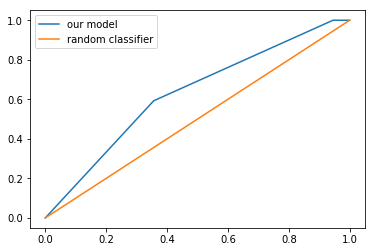

In [283]:
data = (training_examples, training_targets),(validation_examples, validation_targets)
train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2)

In [223]:
# SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK 

In [284]:
def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [285]:
def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [289]:
def train_seq_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = explore_data.get_num_classes(train_labels)
    num_classes = 2
#     unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
#     if len(unexpected_labels):
#         raise ValueError('Unexpected label values found in the validation set:'
#                          ' {unexpected_labels}. Please make sure that the '
#                          'labels in the validation set are in the same range '
#                          'as training labels.'.format(
#                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    print(len(train_texts))
    print(len(val_texts))
    x_train, x_val, word_index = sequence_vectorize(
        train_texts, val_texts)
    print(x_train.shape)
    print(x_val.shape)
    
    # Create model instance.
    model = sepcnn_model(blocks=2, filters=64, kernel_size=3, embedding_dim=200, dropout_rate=0.2, pool_size=3, input_shape=x_train.shape[1:], 
                         num_classes=2, num_features=min(len(word_index) + 1, TOP_K))
    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
#     print('Validation accuracy: {acc}, loss: {loss}'.format(
#             acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Compute training and validation loss.
    
    # Plot Results
    roc_curve(history)
    
    # Save model.
    model.save('twitter_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [ ]:
data = (training_examples, training_targets),(validation_examples, validation_targets)
train_seq_model(data,
                      learning_rate=0.00005,
                      epochs=100,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2)

100
50
(100, 66)
(50, 66)
Train on 100 samples, validate on 50 samples
Epoch 1/100
 - 2s - loss: 0.6931 - acc: 0.5300 - val_loss: 0.6936 - val_acc: 0.4000
Epoch 2/100
 - 0s - loss: 0.6937 - acc: 0.4300 - val_loss: 0.6936 - val_acc: 0.4000
Epoch 3/100
 - 0s - loss: 0.6942 - acc: 0.4400 - val_loss: 0.6936 - val_acc: 0.4000
